# Goal: predict the likelihood of winning a round based on how things stand after the flop or river

Prior work:
- Determined win rates pre-flop based on hole/pocket cards. There I was able to generate a sample of games for each pair of hole cards and calculate the win rate.
- Wrote a hand ranking funtion that considers all possible hands that other players could have and figures out which ones a given hand beats/loses to/ties
  - This function assumes no additional community cards. So it does really good at getting the win rate after the river, but not as well at the turn and worst after the flop.
  - It also assumes just one other player in the hand. But I showed in `n_player_win_rates.ipynb` that raising the win rate to the n-1 power (where n is the number of players) is an effective estimate of the win rate for n players.
  - Each additional unknown card increases the complexity, so while I could take a similar approach and try each possible turn and rivver card, it would take ~50x as long for the turn and ~2500x at the flop. Should benchmark to see what those real durations are.
  - If that proves too inefficient, probably need to just generate a sample of games. it won't be as accurate but it will be a lot faster

In [2]:
import copy
from texas_hold_em_utils.deck import Deck
from texas_hold_em_utils.hands import HandOfFive

def rank_hand_post_flop(hand, flop, n_other_players=1, sample_size=1000):
    deck = Deck()
    deck.remove(hand[0])
    deck.remove(hand[1])

    deck.remove(flop[0])
    deck.remove(flop[1])
    deck.remove(flop[2])

    wins = 0.0

    for i in range(sample_size):
        deck_cpy = copy.deepcopy(deck)
        deck_cpy.shuffle()
        
        turn = deck_cpy.draw()
        river = deck_cpy.draw()
        
        comm = [flop[0], flop[1], flop[2], turn, river]

        other_hands = []
        for j in range(n_other_players):
            other_hands.append(HandOfFive([deck_cpy.draw(), deck_cpy.draw()], comm))
        
        player_hand = HandOfFive(hand, comm)
        
        lost_to = []
        tied_with = []
        
        for hand_obj in other_hands:
            if player_hand < hand_obj:
                lost_to.append(hand_obj)
            elif player_hand == hand_obj:
                tied_with.append(hand_obj)
        
        if len(lost_to) == 0:
            wins += 1 / (len(tied_with) + 1)
            
    return wins/sample_size
            
    

In [3]:
from texas_hold_em_utils.card import Card
import pandas as pd

hand = [Card().from_ints(2, 1), Card().from_ints(3, 1)]

community_cards = [Card().from_ints(9, 1), Card().from_ints(10, 1), Card().from_ints(2, 2)]

df = pd.DataFrame(columns=['wins'])

for i in range(50):
    df = pd.concat([df, pd.DataFrame({'wins': [rank_hand_post_flop(hand, community_cards)]})])

C:\Users\amarl\AppData\Local\Temp\ipykernel_31800\3732414775.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'wins': [rank_hand_post_flop(hand, community_cards)]})])


<Axes: >

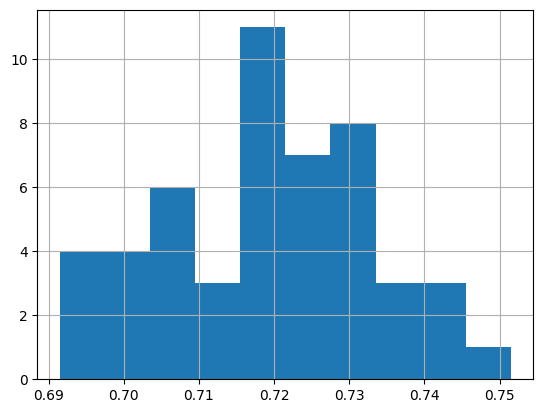

In [4]:
df['wins'].hist()

Distribution is pretty tight, that's good. looks like at a sample size of 1000 we can predict the proportion of wins with a tolerance of +/- 0.03

And it took 10s to generate 50 samples of 1000. So 0.2s to gererate one sample. Pretty good performance

Does it follow the same rule as the end of game one did? where as the number of players goes up we can take the win rate for a 2 player game to the n-1 power?

In [5]:
df = pd.DataFrame(columns=['W_1', 'W_2', 'W_3'])

for i in range(50):
    deck = Deck()
    deck.shuffle()
    hand = [deck.draw(), deck.draw()]
    community_cards = [deck.draw(), deck.draw(), deck.draw()]
    df = pd.concat([df, pd.DataFrame({
        'W_1': [rank_hand_post_flop(hand, community_cards)],
        'W_2': [rank_hand_post_flop(hand, community_cards, n_other_players=2)],
        'W_3': [rank_hand_post_flop(hand, community_cards, n_other_players=3)]
        })])

C:\Users\amarl\AppData\Local\Temp\ipykernel_31800\2387876793.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({


In [6]:
df['W_1_sq'] = df['W_1'] * df['W_1']
df['W_1_cu'] = df['W_1'] * df['W_1'] * df['W_1']

df['W_2_error'] = df['W_1_sq'] - df['W_2']

df['W_3_error'] = df['W_1_sq'] - df['W_3']

<Axes: >

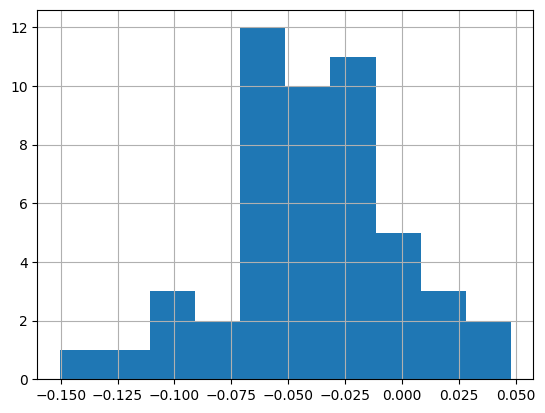

In [7]:
df['W_2_error'].hist()

<Axes: >

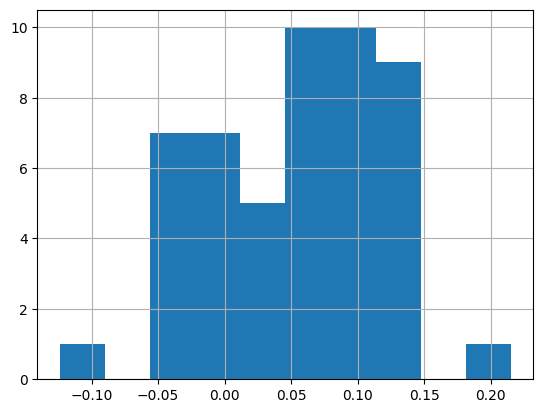

In [8]:
df['W_3_error'].hist()

No it doesn't. Which maybe calls into question those earlier results? or there's something fundementally different about the scenarios. This function's performance doesn't seem to be too effected by the number of players. Generating 2, 3, and 4 player results took 3x as long as generating just the 2 player results

Now on to the turn

In [9]:
def rank_hand_post_turn(hand, flop_and_turn, n_other_players=1, sample_size=1000):
    deck = Deck()
    deck.remove(hand[0])
    deck.remove(hand[1])

    deck.remove(flop_and_turn[0])
    deck.remove(flop_and_turn[1])
    deck.remove(flop_and_turn[2])
    deck.remove(flop_and_turn[3])

    wins = 0.0

    for i in range(sample_size):
        deck_cpy = copy.deepcopy(deck)
        deck_cpy.shuffle()
        
        river = deck_cpy.draw()
        
        comm = [flop_and_turn[0], flop_and_turn[1], flop_and_turn[2], flop_and_turn[3], river]

        other_hands = []
        for j in range(n_other_players):
            other_hands.append(HandOfFive([deck_cpy.draw(), deck_cpy.draw()], comm))
        
        player_hand = HandOfFive(hand, comm)
        
        lost_to = []
        tied_with = []
        
        for hand_obj in other_hands:
            if player_hand < hand_obj:
                lost_to.append(hand_obj)
            elif player_hand == hand_obj:
                tied_with.append(hand_obj)
        
        if len(lost_to) == 0:
            wins += 1 / (len(tied_with) + 1)
            
    return wins/sample_size

In [10]:
df = pd.DataFrame(columns=['W_1', 'W_2', 'W_3'])

for i in range(5):
    deck = Deck()
    deck.shuffle()
    hand = [deck.draw(), deck.draw()]
    community_cards = [deck.draw(), deck.draw(), deck.draw(), deck.draw()]
    df = pd.concat([df, pd.DataFrame({
        'W_1': [rank_hand_post_turn(hand, community_cards)],
        'W_2': [rank_hand_post_turn(hand, community_cards, n_other_players=2)],
        'W_3': [rank_hand_post_turn(hand, community_cards, n_other_players=3)]
        })])

C:\Users\amarl\AppData\Local\Temp\ipykernel_31800\539707621.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({


<Axes: >

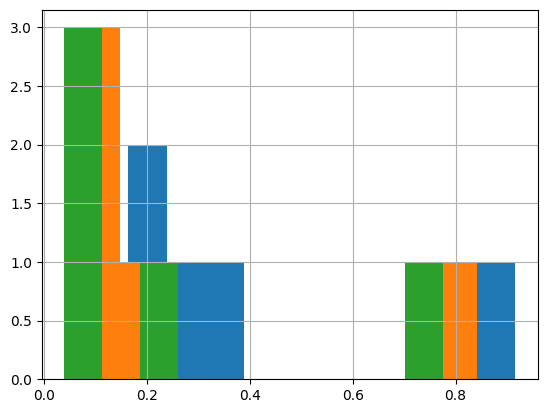

In [11]:
df['W_1'].hist()
df['W_2'].hist()
df['W_3'].hist()

In [12]:
df['W_1_sq'] = df['W_1'] * df['W_1']
df['W_1_cu'] = df['W_1'] * df['W_1'] * df['W_1']

df['W_2_error'] = df['W_1_sq'] - df['W_2']

df['W_3_error'] = df['W_1_sq'] - df['W_3']

<Axes: >

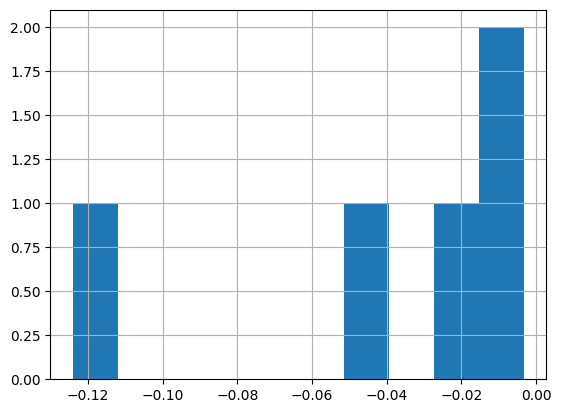

In [13]:
df['W_2_error'].hist()

<Axes: >

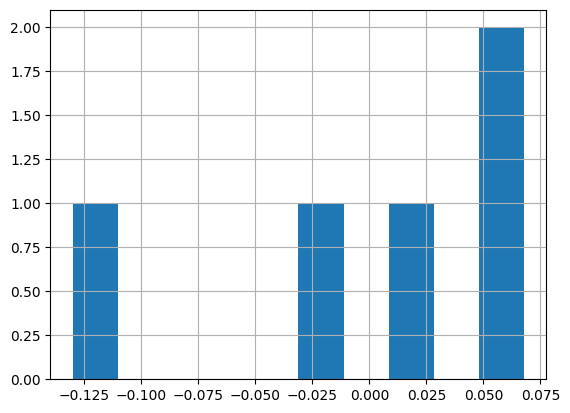

In [14]:
df['W_3_error'].hist()

In [15]:
hand = [Card().from_ints(2, 1), Card().from_ints(3, 1)]

community_cards = [Card().from_ints(9, 1), Card().from_ints(10, 1), Card().from_ints(2, 2), Card().from_ints(5,0)]

df = pd.DataFrame(columns=['wins'])

for i in range(50):
    df = pd.concat([df, pd.DataFrame({'wins': [rank_hand_post_turn(hand, community_cards)]})])

C:\Users\amarl\AppData\Local\Temp\ipykernel_31800\3514283508.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'wins': [rank_hand_post_turn(hand, community_cards)]})])


<Axes: >

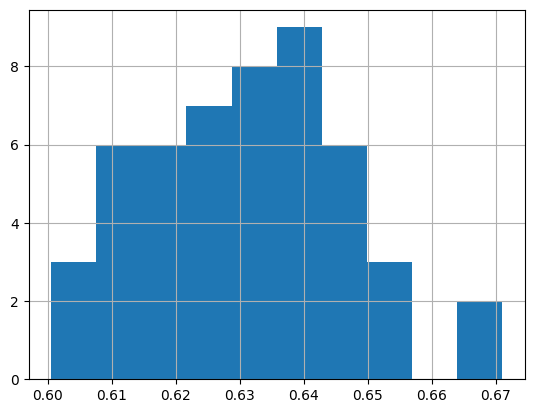

In [16]:
df['wins'].hist()

In [17]:
def rank_hand_post_river(hand, community_cards, n_other_players=1, sample_size=1000):
    deck = Deck()
    deck.remove(hand[0])
    deck.remove(hand[1])

    deck.remove(community_cards[0])
    deck.remove(community_cards[1])
    deck.remove(community_cards[2])
    deck.remove(community_cards[3])
    deck.remove(community_cards[4])

    wins = 0.0

    for i in range(sample_size):
        deck_cpy = copy.deepcopy(deck)
        deck_cpy.shuffle()
        
        comm = [community_cards[0], community_cards[1], community_cards[2], community_cards[3], community_cards[4]]

        other_hands = []
        for j in range(n_other_players):
            other_hands.append(HandOfFive([deck_cpy.draw(), deck_cpy.draw()], comm))
        
        player_hand = HandOfFive(hand, comm)
        
        lost_to = []
        tied_with = []
        
        for hand_obj in other_hands:
            if player_hand < hand_obj:
                lost_to.append(hand_obj)
            elif player_hand == hand_obj:
                tied_with.append(hand_obj)
        
        if len(lost_to) == 0:
            wins += 1 / (len(tied_with) + 1)
            
    return wins/sample_size

<Axes: >

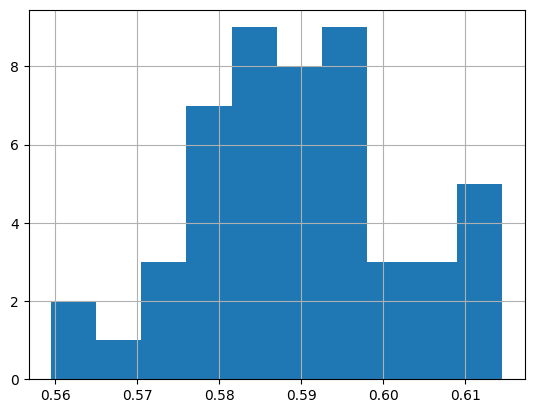

In [23]:
from texas_hold_em_utils.relative_ranking import rank_hand

hand = [Card().from_ints(2, 1), Card().from_ints(3, 1)]

community_cards = [Card().from_ints(9, 1), Card().from_ints(10, 1), Card().from_ints(2, 2), Card().from_ints(5,0), Card().from_ints(10, 0)]

df = pd.DataFrame(columns=['wins'])

for i in range(50):
    df = pd.concat([df, pd.DataFrame({'W_1': [rank_hand_post_river(hand, community_cards)],
                                       'W_2': [rank_hand_post_river(hand, community_cards, n_other_players=2)],
                                       'W_3': [rank_hand_post_river(hand, community_cards, n_other_players=3)]
                                        })])

df['W_1'].hist()

In [19]:
wins, losses, ties = rank_hand(hand, community_cards)

In [25]:
win_rate = (wins + (0.5*ties)) / (wins + ties + losses)
print(f'Win rate: {win_rate}')
print(f"W_1: {df['W_1'].mean()}")

Win rate: 0.5888888888888889
W_1: 0.58929


In [26]:
print(f'Win rate^2: {win_rate * win_rate}')
print(f"W_2: {df['W_2'].mean()}")

Win rate^2: 0.34679012345679017
W_2: 0.33837333333333336


In [28]:
print(f'Win rate^3: {win_rate * win_rate * win_rate}')
print(f"W_3: {df['W_3'].mean()}")

Win rate^3: 0.20422085048010977
W_3: 0.1885933333333333
